# CS440/ECE448 Spring 2023
# MP11: Reinforcement Learning

The first thing you need to do is to download this file: <a href="mp11.zip">mp11.zip</a>.  If you want, you can also download <a href="mp11_extra.zip">mp11_extra.zip</a>, the extra credit assignment.  `mp11.zip` has the following content:

* `submitted.py`: Your homework. Edit, and then submit to <a href="https://www.gradescope.com/courses/486387">Gradescope</a>.
* `mp11_notebook.ipynb`: This is a <a href="https://anaconda.org/anaconda/jupyter">Jupyter</a> notebook to help you debug.  You can completely ignore it if you want, although you might find that it gives you useful instructions.
* `pong.py`: This is a program that plays Pong.  If called interactively, it will call the module `pong_display.py` to create a display, so that you can play.  If told to use a Q-learner, it will call your `submitted.py` to do Q-learning.
* `grade.py`: Once your homework seems to be working, you can test it by typing `python grade.py`, which will run the tests in `tests/tests_visible.py`.
* `tests/test_visible.py`: This file contains about half of the <a href="https://docs.python.org/3/library/unittest.html">unit tests</a> that Gradescope will run in order to grade your homework.  If you can get a perfect score on these tests, then you should also get a perfect score on the additional hidden tests that Gradescope uses.
* `requirements.txt`: This tells you which python packages you need to have installed, in order to run `grade.py`.  You can install all of those packages by typing `pip install -r requirements.txt` or `pip3 install -r requirements.txt`.

This file (`mp11_notebook.ipynb`) will walk you through the whole MP, giving you instructions and debugging tips as you go.

### Table of Contents

1. <a href="#section1">Playing Pong</a>
1. <a href="#section2">Creating a Q-Learner Object</a>
1. <a href="#section3">Epsilon-First Exploration</a>
1. <a href="#section4">Q-Learning</a>
1. <a href="#section5">Saving and Loading Your Q and N Tables</a>
1. <a href="#section6">Exploitation</a>
1. <a href="#section7">Acting</a>
1. <a href="#section8">Training</a>
1. <a href="#section9">Extra Credit</a>
1. <a href="#grade">Grade Your Homework</a>

<a id='section1'></a>

## Playing Pong

Pong was the <a href="https://en.wikipedia.org/wiki/Pong">first video game produced by Atari.</a>  It is a simple game, based on table tennis.  Here is a two-person version of the game: https://commons.wikimedia.org/wiki/File:Pong_Game_Test2.gif

We will be playing a one-person version of the game:

* When the ball hits the top, bottom, or left wall of the playing field, it bounces.
* The right end of the playing field is open, except for the paddle.  If the ball hits the paddle, it bounces, and the player's score increments by one.  If the ball hits the open space, the game is over; the score resets to zero, and a new game begins.

The game is pretty simple, but in order to get a better feeling for it, you may want to try playing it yourself.  Use the up arrow to move the paddle upward, and the down arrow to move the paddle downward.  See how high you can make your score:


In [1]:
# !python pong.py

Once you figure out how to use the arrow keys to control your paddle, we hope you will find that the game is not too hard for a human to play.  However, for a computer, it's difficult to know: where should the paddle be moved at each time step?  In order to see how difficult it is for a computer to play, let's ask the "random" player to play the game.

**WARNING:** The following line will open a pygame window.  The pygame window will be hidden by this window -- in order to see it, you will need to minimize this window.  The pygame window will consume a lot of CPU time just waiting for the processor, so in order to kill it, you will need to come back to this window, click on the block below, then click the Jupyter "stop" button (the square button at the top of this window) in order to stop processing.

In [2]:
# !python pong.py --player random

<a id='section2'></a>

## Creating a Q-Learner Object

The first thing you will do is to create a `q_learner` object that can store your learned Q table and your N table (table of exploration counts).  

Like any other object-oriented language, python permits you to create new object classes in order to store data that will be needed from time to time.  If you are not already very, very familiar with python classes, you might want to study the python class tutorial: https://docs.python.org/3/tutorial/classes.html

Like any other object in python, a `q_learner` object is created by calling its name as a function, e.g., `my_q_learner=submitted.q_learner()`.  Doing so calls the function `submitted.q_learner.__init__()`.  Let's look at the docstring to see what it should do.

In [3]:
import submitted, importlib
importlib.reload(submitted)
help(submitted.q_learner.__init__)

Help on function __init__ in module submitted:

__init__(self, alpha, epsilon, gamma, nfirst, state_cardinality)
    Create a new q_learner object.
    
    @params:
    alpha (scalar) - learning rate of the Q-learner
    epsilon (scalar) - probability of taking a random action
    gamma (scalar) - discount factor        
    nfirst (scalar) - exploring each state/action pair nfirst times before exploiting
    state_cardinality (list) - cardinality of each of the quantized state variables
    
    @return:
    None



Write your `__init__` function to meet the requirements specified in the docstring.  Once you have completed it, the following code should run without errors:

In [4]:
importlib.reload(submitted)

q_learner = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])

print(q_learner)


In [5]:
def scope_test():
    def do_local():
        spam = "local spam"

    def do_nonlocal():
        nonlocal spam
        spam = "nonlocal spam"

    def do_global():
        global spam
        spam = "global spam"

    spam = "test spam"
    do_nonlocal()
    print("After nonlocal assignment:", spam)
    do_local()
    print("After local assignment:", spam)
    do_global()
    print("After global assignment:", spam)

scope_test()
print("In global scope:", spam)

After nonlocal assignment: nonlocal spam
After local assignment: nonlocal spam
After global assignment: nonlocal spam
In global scope: global spam


<a id='section3'></a>

## Epsilon-First Exploration

In order to manage the exploration/exploitation tradeoff, we will be using both "epsilon-first" and "epsilon-greedy" (https://en.wikipedia.org/wiki/Multi-armed_bandit#Semi-uniform_strategies).  

The epsilon-first strategy explores every state/action pair at least `nfirst` times before it ever starts to exploit any strategy.  Your `q_learner` should have a table to keep track of how many times it has explored a state/action pair prior to the start of any exploitation.  The method for storing that table is up to you; in order to have some standardized API, therefore, you need to write a method called `report_exploration_counts` that returns a list of the three exploration counts for a given state. 

In [6]:
importlib.reload(submitted)
help(submitted.q_learner.report_exploration_counts)

Help on function report_exploration_counts in module submitted:

report_exploration_counts(self, state)
    Check to see how many times each action has been explored in this state.
    @params:
    state (list of 5 ints): ball_x, ball_y, ball_vx, ball_vy, paddle_y.
      These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle, all quantized.
      0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
    @return:
    explored_count (array of 3 ints): 
      number of times that each action has been explored from this state.
      The mapping from actions to integers is up to you, but there must be three of them.



Write `report_exploration_counts` so that it returns a list or array for any given state.  Test your code with the following:

In [7]:
importlib.reload(submitted)
q_learner = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
print('This is how many times state [0,0,0,0,0] has been explored so far:')
print(q_learner.report_exploration_counts([0,0,0,0,0]))
print('This is how many times state [9,9,1,1,9] has been explored so far:')
print(q_learner.report_exploration_counts([9,9,1,1,9]))

This is how many times state [0,0,0,0,0] has been explored so far:
[0. 0. 0.]
This is how many times state [9,9,1,1,9] has been explored so far:
[0. 0. 0.]


When your learner first starts learning, it will call the function `choose_unexplored_action` to choose an unexplored action.  This function should choose a function uniformly at random from the set of unexplored actions in a given state, if there are any:

In [8]:
importlib.reload(submitted)
help(submitted.q_learner.choose_unexplored_action)

Help on function choose_unexplored_action in module submitted:

choose_unexplored_action(self, state)
    Choose an action that has been explored less than nfirst times.
    If many actions are underexplored, you should choose uniformly
    from among those actions; don't just choose the first one all
    the time.
    
    @params:
    state (list of 5 ints): ball_x, ball_y, ball_vx, ball_vy, paddle_y.
       These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle, all quantized.
      0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
    @return:
    action (scalar): either -1, or 0, or 1, or None
      If all actions have been explored at least n_explore times, return None.
      Otherwise, choose one uniformly at random from those w/count less than n_explore.
      When you choose an action, you should increment its count in your counter table.



If this has been written correctly, the following block should generate a random sequence of actions.  If the next block produces the same action 5 times in a row, that is the wrong result, and the result would be that your code does not pass the autograder.

In [9]:
importlib.reload(submitted)
q_learner = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))


Next action: -1
Next action: 0
Next action: 0
Next action: 1
Next action: 0


After all three actions have been explored `nfirst` times, the function `choose_unexplored_action` should return `None`, as shown here:

In [10]:
importlib.reload(submitted)
q_learner = submitted.q_learner(0.05,0.05,0.99,1,[10,10,2,2,10])
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))


Next action: -1
Next action: 1
Next action: 0
Next action: None


<a id='section4'></a>

## Q-Learning

The reinforcement learning we are implementing is called Q-learning (https://en.wikipedia.org/wiki/Q-learning).  

Q-learning keeps a table $Q[s,a]$ that specifies the expected utility of action $a$ in state $s$.  The organization of this table is up to you.  In order to have a standard API, the first thing you should implement is a function `report_q` with the following docstring:

In [11]:
importlib.reload(submitted)
help(submitted.q_learner.report_q)

Help on function report_q in module submitted:

report_q(self, state)
    Report the current Q values for the given state.
    @params:
    state (list of 5 ints): ball_x, ball_y, ball_vx, ball_vy, paddle_y.
      These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle, all quantized.
      0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
    @return:
    Q (array of 3 floats): 
      reward plus expected future utility of each of the three actions. 
      The mapping from actions to integers is up to you, but there must be three of them.



When your `q_learner` is first initialized, the value of $Q[state,action]$ should be zero for all state/action pairs, thus the `report_q` function should return lists of zeros:

In [12]:
importlib.reload(submitted)
q_learner=submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
print('Q[0,0,0,0,0] is now:',q_learner.report_q([0,0,0,0,0]))
print('Q[9,9,1,1,9] is now:',q_learner.report_q([9,9,1,1,9]))

Q[0,0,0,0,0] is now: [0. 0. 0.]
Q[9,9,1,1,9] is now: [0. 0. 0.]


There are actually many different Q-learning algorithms available, but when people refer to **Q-learning with no modifier, they usually mean the time-difference (TD) algorithm**.  

- For example, this is the algorithm that's described on the wikipedia page (https://en.wikipedia.org/wiki/Q-learning).  

- This is the algorithm you will implement for this MP.

- In supervised machine learning, the learner tries to imitate a reference label.  
- In reinforcement learning, there is no reference label.  
- Q-learning replaces the reference label with a "local Q" value, which is the utility that was obtained by performing action $a$ in state $s$ one time.  

- It is usually calculated like this:

$$Q_{local}(s_t,a_t) = r_t + \gamma\max_{a_{t+1}}Q(s_{t+1},a_{t+1})$$

where $r_t$ is the reward that was achieved by performing action $a_t$ in state $s_t$, $s_{t+1}$ is the state into which the game transitioned, and $a_{t+1}$ is one of the actions that could be performed in that state.  $Q_{local}$ is computed by your `q_local` function, which has this docstring:  

In [13]:
importlib.reload(submitted)
help(submitted.q_learner.q_local)

Help on function q_local in module submitted:

q_local(self, reward, newstate)
    The update to Q estimated from a single step of game play:
    reward plus gamma times the max of Q[newstate, ...].
    
    @param:
    reward (scalar float): the reward achieved from the current step of game play.
    newstate (list of 5 ints): ball_x, ball_y, ball_vx, ball_vy, paddle_y.
      These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle, all quantized.
      0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
    @return:
    Q_local (scalar float): the local value of Q



Initially, `q_local` should just return the given reward, because initially, all Q values are 0:

In [14]:
importlib.reload(submitted)
q_learner = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,10,10])
print('Q_local(6.25,[9,9,1,1,9]) is currently:',q_learner.q_local(6.25,[9,9,1,1,9]))

Q_local(6.25,[9,9,1,1,9]) is currently: 6.25


Now you can use `q_learner.q_local` as the target for `q_learner.learn`.  The basic algorithm is

$$Q(s,a) = Q(s,a) + \alpha (Q_{local}(s,a)-Q(s,a))$$

Here is the docstring:

In [15]:
importlib.reload(submitted)
help(submitted.q_learner.learn)

Help on function learn in module submitted:

learn(self, state, action, reward, newstate)
    Update the internal Q-table on the basis of an observed
    state, action, reward, newstate sequence.
    
    @params:
    state: a list of 5 numbers: ball_x, ball_y, ball_vx, ball_vy, paddle_y.
      These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle.
    action: an integer, one of -1, 0, or +1
    reward: a reward; positive for hitting the ball, negative for losing a game
    newstate: a list of 5 numbers, in the same format as state
    
    @return:
    None



The following block checks a sequence of Q updates:

1. First, $Q([9,9,1,1,9],-1)$ is updated.  Since all Q values start at zero, it will be updated to just have a value equal to $\alpha$ (0.05) times the given reward (6.25) for a total value of 0.3125.
1. When we print out $Q([9,9,1,1,9],:)$, we see that one of the elements has been updated.
1. Next, update $Q([9,9,1,1,8],1)$ with a given reward, and with $[9,9,1,1,9]$ as the given next state.  Since $Q([9,9,1,1,9],-1)$ is larger than zero, the next-state Q-value should be multiplied by $\gamma$ (0.99) and added to the reward (3.1), then multiplied by $\alpha$, giving a total value of 0.17046875.
1. The resulting Q-value is reported.

In [16]:
importlib.reload(submitted)
q_learner = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
q_learner.learn([9,9,1,1,9],-1,6.25,[0,0,0,0,0])
print('Q[9,9,1,1,9] is now',q_learner.report_q([9,9,1,1,9]))
q_learner.learn([9,9,1,1,8],1,3.1,[9,9,1,1,9])
print('Q[9,9,1,1,8] is now',q_learner.report_q([9,9,1,1,8]))

Q[9,9,1,1,9] is now [0.3125 0.     0.    ]
Q[9,9,1,1,8] is now [0.         0.         0.17046875]


<a id='section5'></a>

## Saving and Loading your Q and N Tables

After you've spent a long time training your `q_learner`, you will want to save your Q and N tables so that you can reload them later.  The format of Q and N is up to you, therefore it's also up to you to write the `save` and `load` functions.  Here are the docstrings:

In [17]:
importlib.reload(submitted)
help(submitted.q_learner.save)

Help on function save in module submitted:

save(self, filename)
    Save your Q and N tables to a file.
    This can save in any format you like, as long as your "load" 
    function uses the same file format.  We recommend numpy.savez,
    but you can use something else if you prefer.
    
    @params:
    filename (str) - filename to which it should be saved
    @return:
    None



In [18]:
importlib.reload(submitted)
help(submitted.q_learner.load)

Help on function load in module submitted:

load(self, filename)
    Load the Q and N tables from a file.
    This should load from whatever file format your save function
    used.  We recommend numpy.load, but you can use something
    else if you prefer.
    
    @params:
    filename (str) - filename from which it should be loaded
    @return:
    None



These functions can be tested by doing one step of training one `q_learner`, then saving its results, then loading them into another `q_learner`:

In [19]:
importlib.reload(submitted)
q_learner1 = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
print('Next action:',q_learner1.choose_unexplored_action([9,9,1,1,9]))
q_learner1.learn([9,9,1,1,9],-1,6.25,[0,0,0,0,0])
print('N1[9,9,1,1,8] is now',q_learner1.report_exploration_counts([9,9,1,1,9]))
print('Q1[9,9,1,1,8] is now',q_learner1.report_q([9,9,1,1,9]))
q_learner1.save('test.npz')

q_learner2 = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
print('N2[9,9,1,1,8] starts out as',q_learner2.report_exploration_counts([9,9,1,1,9]))
print('Q2[9,9,1,1,8] starts out as',q_learner2.report_q([9,9,1,1,9]))
q_learner2.load('test.npz')
print('N2[9,9,1,1,8] is now',q_learner2.report_exploration_counts([9,9,1,1,9]))
print('Q2[9,9,1,1,8] is now',q_learner2.report_q([9,9,1,1,9]))


Next action: 1
N1[9,9,1,1,8] is now [0. 0. 1.]
Q1[9,9,1,1,8] is now [0.3125 0.     0.    ]
N2[9,9,1,1,8] starts out as [0. 0. 0.]
Q2[9,9,1,1,8] starts out as [0. 0. 0.]
N2[9,9,1,1,8] is now [0. 0. 1.]
Q2[9,9,1,1,8] is now [0.3125 0.     0.    ]


<a id='section6'></a>

## Exploitation

A reinforcement learner always has to trade off between exploration (choosing an action at random) versus exploitation (choosing the action with the maximum expected utility).  Before we worry about that tradeoff, though, let's first make sure that exploitation works.

In [20]:
importlib.reload(submitted)
help(submitted.q_learner.exploit)

Help on function exploit in module submitted:

exploit(self, state)
    Return the action that has the highest Q-value for the current state, and its Q-value.
    @params:
    state (list of 5 ints): ball_x, ball_y, ball_vx, ball_vy, paddle_y.
      These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle, all quantized.
      0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
    @return:
    action (scalar int): either -1, or 0, or 1.
      The action that has the highest Q-value.  Ties can be broken any way you want.
    Q (scalar float): 
      The Q-value of the selected action



In [21]:
importlib.reload(submitted)
q_learner1 = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
q_learner1.learn([9,9,1,1,9],-1,6.25,[0,0,0,0,0])
print('Q1[9,9,1,1,9] is now',q_learner1.report_q([9,9,1,1,9]))
print('The best action and Q from state [9,9,1,1,9] are',q_learner1.exploit([9,9,1,1,9]))

Q1[9,9,1,1,9] is now [0.3125 0.     0.    ]
The best action and Q from state [9,9,1,1,9] are (-1, 0.3125)


<a id='section7'></a>

## Acting

When your learner decides which action to perform, it should trade off exploration vs. exploitation using both the epsilon-first and the epsilon-greedy strategies:
1. If there is any action that has been explored fewer than `nfirst` times, then choose one of those actions at random.  Otherwise...
1. With probability `epsilon`, choose an action at random.  Otherwise...
1. Exploit.


In [22]:
importlib.reload(submitted)
help(submitted.q_learner.act)

Help on function act in module submitted:

act(self, state)
    Decide what action to take in the current state.
    
    - If any action has been taken less than nfirst times, 
      - then choose one of those actions, uniformly at random.
    
    - Otherwise, with probability epsilon, choose an action uniformly at random.
    
    - Otherwise, choose the action with the best Q(state,action).
    
    @params: 
    state: a list of 5 integers: ball_x, ball_y, ball_vx, ball_vy, paddle_y.
      These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle, all quantized.
      0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
    @return:
    -1 if the paddle should move upward
    0 if the paddle should be stationary
    1 if the paddle should move downward



In [23]:
 
import random
 
# 生成第一个随机数
print( "random() : ", random.random())
 
# 生成第二个随机数
print( "random() : ", random.random())

random() :  0.25861000858143524
random() :  0.7864804938233956


In order to test all three types of action (epsilon-first exploration, epsilon-greedy exploration, and exploitation), let's create a learner with `nfirst=1` and `epsilon=0.25`, and set it so that the best action from state `[9,9,1,1,9]` is `-1`.  With these settings, a sequence of calls to `q_learner.act` should produce the following sequence of actions:

1. The first three actions should include each possible action once.
1. After the first three actions, 3/4 of the remaining actions should be `-1`.  The remaining 1/4 should be randomly chosen.

In [24]:
importlib.reload(submitted)
q_learner=submitted.q_learner(0.05,0.25,0.99,1,[10,10,2,2,10])
q_learner.learn([9,9,1,1,9],-1,6.25,[0,0,0,0,0])
print('An epsilon-first action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-first action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-first action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))

An epsilon-first action: 0
An epsilon-first action: -1
An epsilon-first action: 1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: 0
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: -1


<a id='section8'></a>

## Training

Now that all of your components work, you can try training your algorithm.  Do this by giving your `q_learner` as a player to a new `pong.PongGame` object.  Set `visibility=False` so that the `PongGame` doesn't create a new window.

In [25]:
import pong, importlib, submitted
importlib.reload(pong)
help(pong.PongGame.__init__)

Help on function __init__ in module pong:

__init__(self, ball_speed=4, paddle_speed=8, learner=None, visible=True, state_quantization=[10, 10, 2, 2, 10])
    Create a new pong game, with a specified player.
    
    @params:
    ball_speed (scalar int) - average ball speed in pixels/frame
    paddle_speed (scalar int) - paddle moves 0, +paddle_speed, or -paddle_speed
    learner - can be None if the player is human.  If not None, should be an 
      object of type random_learner, submitted.q_learner, or submitted.deep_q.
    visible (bool) - should this game have an attached pygame window?
    state_quantization (list) - if not None, state variables are quantized
      into integers of these cardinalities before being passed to the learner.



As you can see, we should set `visibility=False` so that the `PongGame` doesn't create a new window.  We should also make sure that the PongGame uses the same state quantization as the learner.

In [7]:
import importlib
import pong
import submitted
importlib.reload(pong)
importlib.reload(submitted)
state_quantization = [10,10,2,2,10]
q_learner=submitted.q_learner(0.05,0.05,0.99,5,state_quantization)

pong_game = pong.PongGame(learner=q_learner, visible=False, state_quantization=state_quantization)
print(pong_game)

In order to train our learner, we want it to play the game many times.  To do that we use the PongGame.run function:

In [27]:
help(pong_game.run)


Help on method run in module pong:

run(m_rewards=inf, m_games=inf, m_frames=inf, states=[]) method of pong.PongGame instance
    Run the game.
    @param
    m_frames (scalar int): maximum number of frames to be played
    m_rewards (scalar int): maximum number of rewards earned (+ or -)
    m_games (scalar int): maximum number of games
    states (list): list of states whose Q-values should be returned
       each state is a list of 5 ints: ball_x, ball_y, ball_vx, ball_vy, paddle_y.
       These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
       and the y-position of the paddle, all quantized.
       0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
      
    @return
    scores (list): list of scores of all completed games
    
    The following will be returned only if the player is q_learning or deep_q.
    New elements will be added to these lists once/frame if m_frames is specified,
    else once/reward if m_rewards is specified, else once

In order to make sure our learner is learning, let's tell `pong_game.run` to output all 3 Q-values of all of the 4000 states in every time step.

To make sure that's not an outrageous amount of data, let's tell it to only output the Q values once/reward, and ask it to only collect 5000 rewards:


In [8]:
states = [[x,y,vx,vy,py] for x in range(10) for y in range(10) for vx in range(2) for vy in range(2) for py in range(10) ]

scores, q_achieved, q_states = pong_game.run(m_rewards=500, states=states)
q_learner.save('trained_model.npz')

print('The number of games played was',len(scores))
print('The number of rewards was',len(q_states))
print('The size of each returned Q-matrix was',q_states[0].shape)


Completed 0 games, 1 rewards, 255 frames, score 0, max score 0
Completed 1 games, 2 rewards, 463 frames, score 0, max score 0
Completed 2 games, 3 rewards, 717 frames, score 0, max score 0
Completed 3 games, 4 rewards, 971 frames, score 0, max score 0
Completed 4 games, 7 rewards, 1462 frames, score 2, max score 2
Completed 5 games, 8 rewards, 1670 frames, score 0, max score 2
Completed 6 games, 9 rewards, 1924 frames, score 0, max score 2
Completed 7 games, 11 rewards, 2322 frames, score 1, max score 2
Completed 8 games, 13 rewards, 2750 frames, score 1, max score 2
Completed 9 games, 15 rewards, 3293 frames, score 1, max score 2
Completed 10 games, 16 rewards, 3547 frames, score 0, max score 2
Completed 11 games, 17 rewards, 3755 frames, score 0, max score 2
Completed 12 games, 19 rewards, 4252 frames, score 1, max score 2
Completed 13 games, 20 rewards, 4506 frames, score 0, max score 2
Completed 14 games, 21 rewards, 4760 frames, score 0, max score 2
Completed 15 games, 22 rewards,

Completed 133 games, 204 rewards, 48649 frames, score 2, max score 5
Completed 134 games, 205 rewards, 48903 frames, score 0, max score 5
Completed 135 games, 206 rewards, 49157 frames, score 0, max score 5
Completed 136 games, 208 rewards, 49669 frames, score 1, max score 5
Completed 137 games, 210 rewards, 50331 frames, score 1, max score 5
Completed 138 games, 212 rewards, 50759 frames, score 1, max score 5
Completed 139 games, 213 rewards, 51013 frames, score 0, max score 5
Completed 140 games, 215 rewards, 51418 frames, score 1, max score 5
Completed 141 games, 216 rewards, 51599 frames, score 0, max score 5
Completed 142 games, 217 rewards, 51780 frames, score 0, max score 5
Completed 143 games, 218 rewards, 52034 frames, score 0, max score 5
Completed 144 games, 219 rewards, 52242 frames, score 0, max score 5
Completed 145 games, 220 rewards, 52496 frames, score 0, max score 5
Completed 146 games, 221 rewards, 52704 frames, score 0, max score 5
Completed 147 games, 222 rewards, 

Completed 255 games, 390 rewards, 94815 frames, score 0, max score 5
Completed 256 games, 392 rewards, 95278 frames, score 1, max score 5
Completed 257 games, 393 rewards, 95532 frames, score 0, max score 5
Completed 258 games, 395 rewards, 95937 frames, score 1, max score 5
Completed 259 games, 396 rewards, 96191 frames, score 0, max score 5
Completed 260 games, 398 rewards, 97110 frames, score 1, max score 5
Completed 261 games, 400 rewards, 97712 frames, score 1, max score 5
Completed 262 games, 401 rewards, 97966 frames, score 0, max score 5
Completed 263 games, 402 rewards, 98147 frames, score 0, max score 5
Completed 264 games, 404 rewards, 98737 frames, score 1, max score 5
Completed 265 games, 405 rewards, 98918 frames, score 0, max score 5
Completed 266 games, 409 rewards, 99954 frames, score 3, max score 5
Completed 267 games, 412 rewards, 100458 frames, score 2, max score 5
Completed 268 games, 415 rewards, 101542 frames, score 2, max score 5
Completed 269 games, 416 rewards

The returned value of `q_states` is a list of 4000x3 numpy arrays (20 states, 3 actions).  The list contains `m_rewards` of these. We want to convert it into something that matplotlib can plot.  

In [9]:
import numpy as np

Q = np.array([np.reshape(q,-1) for q in q_states])
print('Q is now of shape',Q.shape)
print('the max absolute value of Q is ',np.amax(abs(Q)))

Q is now of shape (500, 12000)
the max absolute value of Q is  2.9035269057297883


Text(0, 0.5, 'Reward number')

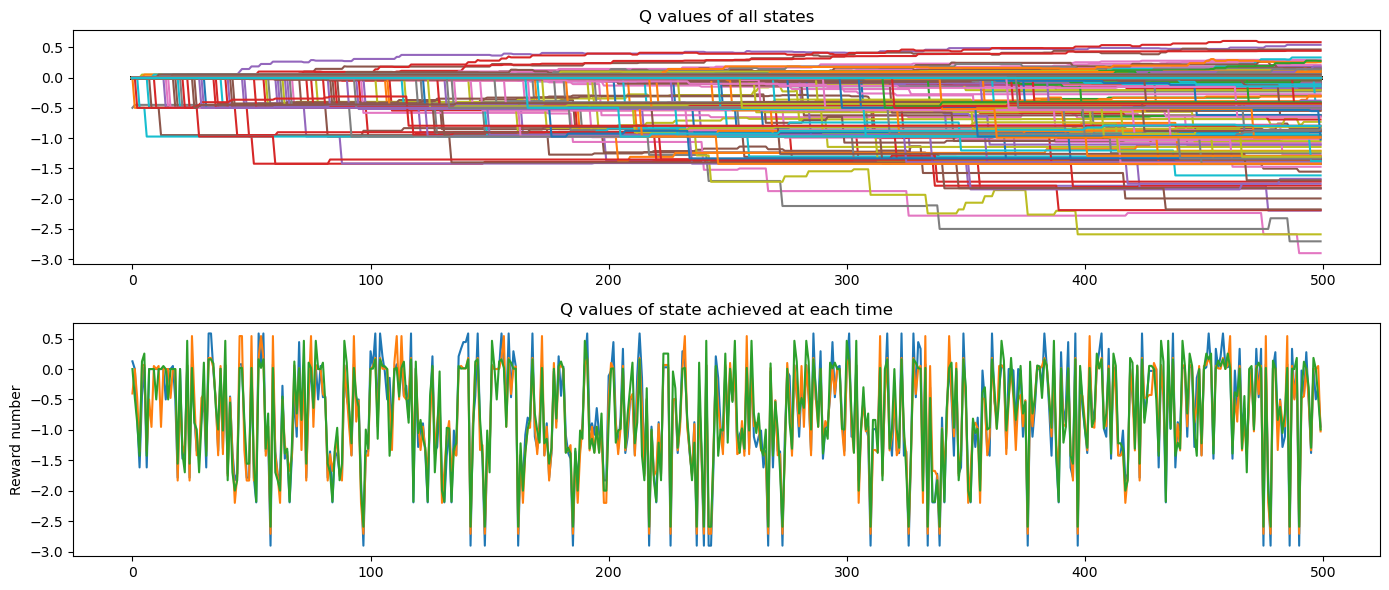

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14,6),layout='tight')
ax = [ fig.add_subplot(2,1,x) for x in range(1,3) ]
ax[0].plot(np.arange(0,len(q_states)),Q)
ax[0].set_title('Q values of all states')
ax[1].plot(np.arange(0,len(q_states)),q_achieved)
ax[1].set_title('Q values of state achieved at each time')
ax[1].set_ylabel('Reward number')

OK, now let's try running it for a much longer period -- say, 5000 complete games.  We won't ask it to print out any states this time.

In [31]:
scores, q_achieved, q_states = pong_game.run(m_games=5000, states=[])

print('The number of games played was',len(scores))
print('The number of video frames was',len(q_states))
print('The size of each returned Q-matrix was',q_states[0].shape)


Completed 0 games, 1 rewards, 182 frames, score 0, max score 7
Completed 1 games, 2 rewards, 390 frames, score 0, max score 7
Completed 2 games, 3 rewards, 644 frames, score 0, max score 7
Completed 3 games, 4 rewards, 825 frames, score 0, max score 7
Completed 4 games, 6 rewards, 1285 frames, score 1, max score 7
Completed 5 games, 8 rewards, 1653 frames, score 1, max score 7
Completed 6 games, 10 rewards, 2131 frames, score 1, max score 7
Completed 7 games, 11 rewards, 2312 frames, score 0, max score 7
Completed 8 games, 13 rewards, 2809 frames, score 1, max score 7
Completed 9 games, 16 rewards, 3774 frames, score 2, max score 7
Completed 10 games, 17 rewards, 3982 frames, score 0, max score 7
Completed 11 games, 21 rewards, 4758 frames, score 3, max score 7
Completed 12 games, 23 rewards, 5145 frames, score 1, max score 7
Completed 13 games, 24 rewards, 5353 frames, score 0, max score 7
Completed 14 games, 26 rewards, 5790 frames, score 1, max score 7
Completed 15 games, 27 rewards

Completed 140 games, 294 rewards, 70779 frames, score 1, max score 7
Completed 141 games, 296 rewards, 71441 frames, score 1, max score 7
Completed 142 games, 298 rewards, 72175 frames, score 1, max score 7
Completed 143 games, 299 rewards, 72429 frames, score 0, max score 7
Completed 144 games, 302 rewards, 73447 frames, score 2, max score 7
Completed 145 games, 304 rewards, 73788 frames, score 1, max score 7
Completed 146 games, 306 rewards, 74194 frames, score 1, max score 7
Completed 147 games, 309 rewards, 75058 frames, score 2, max score 7
Completed 148 games, 310 rewards, 75266 frames, score 0, max score 7
Completed 149 games, 312 rewards, 75634 frames, score 1, max score 7
Completed 150 games, 315 rewards, 76399 frames, score 2, max score 7
Completed 151 games, 316 rewards, 76653 frames, score 0, max score 7
Completed 152 games, 317 rewards, 76834 frames, score 0, max score 7
Completed 153 games, 318 rewards, 77042 frames, score 0, max score 7
Completed 154 games, 319 rewards, 

Completed 282 games, 630 rewards, 154289 frames, score 3, max score 12
Completed 283 games, 634 rewards, 155123 frames, score 3, max score 12
Completed 284 games, 635 rewards, 155331 frames, score 0, max score 12
Completed 285 games, 639 rewards, 156104 frames, score 3, max score 12
Completed 286 games, 640 rewards, 156285 frames, score 0, max score 12
Completed 287 games, 641 rewards, 156466 frames, score 0, max score 12
Completed 288 games, 642 rewards, 156647 frames, score 0, max score 12
Completed 289 games, 646 rewards, 157491 frames, score 3, max score 12
Completed 290 games, 651 rewards, 159728 frames, score 4, max score 12
Completed 291 games, 654 rewards, 160606 frames, score 2, max score 12
Completed 292 games, 657 rewards, 161138 frames, score 2, max score 12
Completed 293 games, 658 rewards, 161319 frames, score 0, max score 12
Completed 294 games, 664 rewards, 162150 frames, score 5, max score 12
Completed 295 games, 665 rewards, 162358 frames, score 0, max score 12
Comple

Completed 414 games, 955 rewards, 236384 frames, score 1, max score 12
Completed 415 games, 959 rewards, 237314 frames, score 3, max score 12
Completed 416 games, 970 rewards, 239288 frames, score 10, max score 12
Completed 417 games, 974 rewards, 240001 frames, score 3, max score 12
Completed 418 games, 980 rewards, 241004 frames, score 5, max score 12
Completed 419 games, 992 rewards, 243617 frames, score 11, max score 12
Completed 420 games, 994 rewards, 244219 frames, score 1, max score 12
Completed 421 games, 998 rewards, 244925 frames, score 3, max score 12
Completed 422 games, 999 rewards, 245179 frames, score 0, max score 12
Completed 423 games, 1003 rewards, 246175 frames, score 3, max score 12
Completed 424 games, 1006 rewards, 246655 frames, score 2, max score 12
Completed 425 games, 1009 rewards, 247191 frames, score 2, max score 12
Completed 426 games, 1011 rewards, 247925 frames, score 1, max score 12
Completed 427 games, 1013 rewards, 248437 frames, score 1, max score 12

Completed 556 games, 1449 rewards, 356128 frames, score 16, max score 16
Completed 557 games, 1453 rewards, 357109 frames, score 3, max score 16
Completed 558 games, 1458 rewards, 358041 frames, score 4, max score 16
Completed 559 games, 1463 rewards, 358906 frames, score 4, max score 16
Completed 560 games, 1464 rewards, 359087 frames, score 0, max score 16
Completed 561 games, 1467 rewards, 359577 frames, score 2, max score 16
Completed 562 games, 1472 rewards, 360605 frames, score 4, max score 16
Completed 563 games, 1476 rewards, 361506 frames, score 3, max score 16
Completed 564 games, 1479 rewards, 362047 frames, score 2, max score 16
Completed 565 games, 1482 rewards, 362754 frames, score 2, max score 16
Completed 566 games, 1487 rewards, 363758 frames, score 4, max score 16
Completed 567 games, 1491 rewards, 364721 frames, score 3, max score 16
Completed 568 games, 1496 rewards, 366862 frames, score 4, max score 16
Completed 569 games, 1499 rewards, 367815 frames, score 2, max 

Completed 674 games, 1818 rewards, 453487 frames, score 10, max score 16
Completed 675 games, 1820 rewards, 453947 frames, score 1, max score 16
Completed 676 games, 1822 rewards, 454444 frames, score 1, max score 16
Completed 677 games, 1825 rewards, 455124 frames, score 2, max score 16
Completed 678 games, 1827 rewards, 455612 frames, score 1, max score 16
Completed 679 games, 1829 rewards, 456010 frames, score 1, max score 16
Completed 680 games, 1833 rewards, 458689 frames, score 3, max score 16
Completed 681 games, 1836 rewards, 459604 frames, score 2, max score 16
Completed 682 games, 1842 rewards, 462046 frames, score 5, max score 16
Completed 683 games, 1843 rewards, 462227 frames, score 0, max score 16
Completed 684 games, 1844 rewards, 462408 frames, score 0, max score 16
Completed 685 games, 1850 rewards, 464104 frames, score 5, max score 16
Completed 686 games, 1854 rewards, 465142 frames, score 3, max score 16
Completed 687 games, 1857 rewards, 465665 frames, score 2, max 

Completed 791 games, 2296 rewards, 591767 frames, score 5, max score 16
Completed 792 games, 2299 rewards, 592486 frames, score 2, max score 16
Completed 793 games, 2303 rewards, 593205 frames, score 3, max score 16
Completed 794 games, 2305 rewards, 593572 frames, score 1, max score 16
Completed 795 games, 2310 rewards, 594933 frames, score 4, max score 16
Completed 796 games, 2314 rewards, 595754 frames, score 3, max score 16
Completed 797 games, 2315 rewards, 595935 frames, score 0, max score 16
Completed 798 games, 2318 rewards, 596425 frames, score 2, max score 16
Completed 799 games, 2319 rewards, 596606 frames, score 0, max score 16
Completed 800 games, 2324 rewards, 598103 frames, score 4, max score 16
Completed 801 games, 2331 rewards, 599323 frames, score 6, max score 16
Completed 802 games, 2342 rewards, 604057 frames, score 10, max score 16
Completed 803 games, 2346 rewards, 605867 frames, score 3, max score 16
Completed 804 games, 2348 rewards, 606418 frames, score 1, max 

Completed 911 games, 2865 rewards, 752551 frames, score 16, max score 19
Completed 912 games, 2866 rewards, 752805 frames, score 0, max score 19
Completed 913 games, 2875 rewards, 754679 frames, score 8, max score 19
Completed 914 games, 2876 rewards, 754887 frames, score 0, max score 19
Completed 915 games, 2879 rewards, 755424 frames, score 2, max score 19
Completed 916 games, 2880 rewards, 755632 frames, score 0, max score 19
Completed 917 games, 2884 rewards, 756464 frames, score 3, max score 19
Completed 918 games, 2887 rewards, 757221 frames, score 2, max score 19
Completed 919 games, 2891 rewards, 757885 frames, score 3, max score 19
Completed 920 games, 2895 rewards, 759519 frames, score 3, max score 19
Completed 921 games, 2906 rewards, 761460 frames, score 10, max score 19
Completed 922 games, 2907 rewards, 761641 frames, score 0, max score 19
Completed 923 games, 2914 rewards, 763411 frames, score 6, max score 19
Completed 924 games, 2919 rewards, 764362 frames, score 4, max

Completed 1030 games, 3353 rewards, 880816 frames, score 6, max score 19
Completed 1031 games, 3358 rewards, 881746 frames, score 4, max score 19
Completed 1032 games, 3361 rewards, 882547 frames, score 2, max score 19
Completed 1033 games, 3362 rewards, 882728 frames, score 0, max score 19
Completed 1034 games, 3368 rewards, 884167 frames, score 5, max score 19
Completed 1035 games, 3369 rewards, 884375 frames, score 0, max score 19
Completed 1036 games, 3370 rewards, 884556 frames, score 0, max score 19
Completed 1037 games, 3373 rewards, 885452 frames, score 2, max score 19
Completed 1038 games, 3377 rewards, 886273 frames, score 3, max score 19
Completed 1039 games, 3379 rewards, 886614 frames, score 1, max score 19
Completed 1040 games, 3384 rewards, 887646 frames, score 4, max score 19
Completed 1041 games, 3394 rewards, 889995 frames, score 9, max score 19
Completed 1042 games, 3402 rewards, 892195 frames, score 7, max score 19
Completed 1043 games, 3403 rewards, 892376 frames, 

Completed 1147 games, 3881 rewards, 1025202 frames, score 7, max score 19
Completed 1148 games, 3883 rewards, 1025554 frames, score 1, max score 19
Completed 1149 games, 3889 rewards, 1028040 frames, score 5, max score 19
Completed 1150 games, 3892 rewards, 1028557 frames, score 2, max score 19
Completed 1151 games, 3921 rewards, 1043978 frames, score 28, max score 28
Completed 1152 games, 3925 rewards, 1045224 frames, score 3, max score 28
Completed 1153 games, 3930 rewards, 1046551 frames, score 4, max score 28
Completed 1154 games, 3949 rewards, 1056802 frames, score 18, max score 28
Completed 1155 games, 3956 rewards, 1058338 frames, score 6, max score 28
Completed 1156 games, 3959 rewards, 1058895 frames, score 2, max score 28
Completed 1157 games, 3962 rewards, 1059646 frames, score 2, max score 28
Completed 1158 games, 3974 rewards, 1061852 frames, score 11, max score 28
Completed 1159 games, 3975 rewards, 1062106 frames, score 0, max score 28
Completed 1160 games, 3978 rewards,

Completed 1264 games, 4414 rewards, 1185541 frames, score 1, max score 28
Completed 1265 games, 4418 rewards, 1186402 frames, score 3, max score 28
Completed 1266 games, 4421 rewards, 1186910 frames, score 2, max score 28
Completed 1267 games, 4422 rewards, 1187091 frames, score 0, max score 28
Completed 1268 games, 4423 rewards, 1187272 frames, score 0, max score 28
Completed 1269 games, 4427 rewards, 1188385 frames, score 3, max score 28
Completed 1270 games, 4428 rewards, 1188593 frames, score 0, max score 28
Completed 1271 games, 4429 rewards, 1188801 frames, score 0, max score 28
Completed 1272 games, 4431 rewards, 1189168 frames, score 1, max score 28
Completed 1273 games, 4436 rewards, 1190596 frames, score 4, max score 28
Completed 1274 games, 4438 rewards, 1191130 frames, score 1, max score 28
Completed 1275 games, 4442 rewards, 1191918 frames, score 3, max score 28
Completed 1276 games, 4443 rewards, 1192172 frames, score 0, max score 28
Completed 1277 games, 4447 rewards, 11

Completed 1375 games, 4957 rewards, 1345932 frames, score 13, max score 41
Completed 1376 games, 4958 rewards, 1346113 frames, score 0, max score 41
Completed 1377 games, 4961 rewards, 1346854 frames, score 2, max score 41
Completed 1378 games, 4967 rewards, 1348307 frames, score 5, max score 41
Completed 1379 games, 4971 rewards, 1349494 frames, score 3, max score 41
Completed 1380 games, 4973 rewards, 1349957 frames, score 1, max score 41
Completed 1381 games, 4978 rewards, 1350904 frames, score 4, max score 41
Completed 1382 games, 4984 rewards, 1352393 frames, score 5, max score 41
Completed 1383 games, 4987 rewards, 1353149 frames, score 2, max score 41
Completed 1384 games, 4994 rewards, 1354239 frames, score 6, max score 41
Completed 1385 games, 4998 rewards, 1355073 frames, score 3, max score 41
Completed 1386 games, 5002 rewards, 1355962 frames, score 3, max score 41
Completed 1387 games, 5010 rewards, 1357512 frames, score 7, max score 41
Completed 1388 games, 5014 rewards, 1

Completed 1492 games, 5506 rewards, 1495534 frames, score 8, max score 41
Completed 1493 games, 5514 rewards, 1497154 frames, score 7, max score 41
Completed 1494 games, 5516 rewards, 1497582 frames, score 1, max score 41
Completed 1495 games, 5527 rewards, 1499903 frames, score 10, max score 41
Completed 1496 games, 5528 rewards, 1500111 frames, score 0, max score 41
Completed 1497 games, 5545 rewards, 1503769 frames, score 16, max score 41
Completed 1498 games, 5565 rewards, 1509059 frames, score 19, max score 41
Completed 1499 games, 5568 rewards, 1509565 frames, score 2, max score 41
Completed 1500 games, 5573 rewards, 1510659 frames, score 4, max score 41
Completed 1501 games, 5607 rewards, 1523762 frames, score 33, max score 41
Completed 1502 games, 5612 rewards, 1525099 frames, score 4, max score 41
Completed 1503 games, 5617 rewards, 1525998 frames, score 4, max score 41
Completed 1504 games, 5618 rewards, 1526179 frames, score 0, max score 41
Completed 1505 games, 5626 rewards

Completed 1614 games, 6251 rewards, 1708674 frames, score 10, max score 41
Completed 1615 games, 6255 rewards, 1709804 frames, score 3, max score 41
Completed 1616 games, 6258 rewards, 1710526 frames, score 2, max score 41
Completed 1617 games, 6262 rewards, 1711690 frames, score 3, max score 41
Completed 1618 games, 6270 rewards, 1713216 frames, score 7, max score 41
Completed 1619 games, 6271 rewards, 1713424 frames, score 0, max score 41
Completed 1620 games, 6279 rewards, 1715757 frames, score 7, max score 41
Completed 1621 games, 6285 rewards, 1717260 frames, score 5, max score 41
Completed 1622 games, 6289 rewards, 1718065 frames, score 3, max score 41
Completed 1623 games, 6294 rewards, 1719127 frames, score 4, max score 41
Completed 1624 games, 6295 rewards, 1719335 frames, score 0, max score 41
Completed 1625 games, 6304 rewards, 1721244 frames, score 8, max score 41
Completed 1626 games, 6311 rewards, 1722673 frames, score 6, max score 41
Completed 1627 games, 6313 rewards, 1

Completed 1726 games, 6975 rewards, 1934036 frames, score 9, max score 41
Completed 1727 games, 6979 rewards, 1935286 frames, score 3, max score 41
Completed 1728 games, 6981 rewards, 1935684 frames, score 1, max score 41
Completed 1729 games, 6990 rewards, 1937454 frames, score 8, max score 41
Completed 1730 games, 7001 rewards, 1939665 frames, score 10, max score 41
Completed 1731 games, 7009 rewards, 1941195 frames, score 7, max score 41
Completed 1732 games, 7024 rewards, 1951605 frames, score 14, max score 41
Completed 1733 games, 7032 rewards, 1953073 frames, score 7, max score 41
Completed 1734 games, 7035 rewards, 1953638 frames, score 2, max score 41
Completed 1735 games, 7042 rewards, 1955805 frames, score 6, max score 41
Completed 1736 games, 7051 rewards, 1958609 frames, score 8, max score 41
Completed 1737 games, 7054 rewards, 1959377 frames, score 2, max score 41
Completed 1738 games, 7056 rewards, 1959814 frames, score 1, max score 41
Completed 1739 games, 7069 rewards, 

Completed 1843 games, 8195 rewards, 2280176 frames, score 11, max score 51
Completed 1844 games, 8206 rewards, 2283784 frames, score 10, max score 51
Completed 1845 games, 8212 rewards, 2284824 frames, score 5, max score 51
Completed 1846 games, 8215 rewards, 2285330 frames, score 2, max score 51
Completed 1847 games, 8218 rewards, 2285836 frames, score 2, max score 51
Completed 1848 games, 8227 rewards, 2287559 frames, score 8, max score 51
Completed 1849 games, 8234 rewards, 2291013 frames, score 6, max score 51
Completed 1850 games, 8237 rewards, 2291567 frames, score 2, max score 51
Completed 1851 games, 8248 rewards, 2293265 frames, score 10, max score 51
Completed 1852 games, 8255 rewards, 2294789 frames, score 6, max score 51
Completed 1853 games, 8267 rewards, 2297198 frames, score 11, max score 51
Completed 1854 games, 8281 rewards, 2299817 frames, score 13, max score 51
Completed 1855 games, 8289 rewards, 2301552 frames, score 7, max score 51
Completed 1856 games, 8293 reward

Completed 1961 games, 9192 rewards, 2560714 frames, score 10, max score 51
Completed 1962 games, 9196 rewards, 2561387 frames, score 3, max score 51
Completed 1963 games, 9208 rewards, 2565143 frames, score 11, max score 51
Completed 1964 games, 9212 rewards, 2566430 frames, score 3, max score 51
Completed 1965 games, 9227 rewards, 2570436 frames, score 14, max score 51
Completed 1966 games, 9239 rewards, 2575120 frames, score 11, max score 51
Completed 1967 games, 9253 rewards, 2577524 frames, score 13, max score 51
Completed 1968 games, 9261 rewards, 2581303 frames, score 7, max score 51
Completed 1969 games, 9273 rewards, 2583259 frames, score 11, max score 51
Completed 1970 games, 9278 rewards, 2584206 frames, score 4, max score 51
Completed 1971 games, 9295 rewards, 2586937 frames, score 16, max score 51
Completed 1972 games, 9338 rewards, 2606429 frames, score 42, max score 51
Completed 1973 games, 9345 rewards, 2608170 frames, score 6, max score 51
Completed 1974 games, 9350 rew

Completed 2072 games, 10403 rewards, 2899289 frames, score 7, max score 51
Completed 2073 games, 10429 rewards, 2905210 frames, score 25, max score 51
Completed 2074 games, 10444 rewards, 2908445 frames, score 14, max score 51
Completed 2075 games, 10453 rewards, 2910140 frames, score 8, max score 51
Completed 2076 games, 10462 rewards, 2912670 frames, score 8, max score 51
Completed 2077 games, 10468 rewards, 2914612 frames, score 5, max score 51
Completed 2078 games, 10480 rewards, 2919428 frames, score 11, max score 51
Completed 2079 games, 10487 rewards, 2921844 frames, score 6, max score 51
Completed 2080 games, 10495 rewards, 2923224 frames, score 7, max score 51
Completed 2081 games, 10524 rewards, 2930564 frames, score 28, max score 51
Completed 2082 games, 10530 rewards, 2931695 frames, score 5, max score 51
Completed 2083 games, 10536 rewards, 2933182 frames, score 5, max score 51
Completed 2084 games, 10543 rewards, 2934436 frames, score 6, max score 51
Completed 2085 games,

Completed 2183 games, 11524 rewards, 3198356 frames, score 7, max score 51
Completed 2184 games, 11544 rewards, 3204803 frames, score 19, max score 51
Completed 2185 games, 11553 rewards, 3206470 frames, score 8, max score 51
Completed 2186 games, 11588 rewards, 3213909 frames, score 34, max score 51
Completed 2187 games, 11592 rewards, 3214534 frames, score 3, max score 51
Completed 2188 games, 11599 rewards, 3215999 frames, score 6, max score 51
Completed 2189 games, 11603 rewards, 3216768 frames, score 3, max score 51
Completed 2190 games, 11612 rewards, 3218460 frames, score 8, max score 51
Completed 2191 games, 11617 rewards, 3219328 frames, score 4, max score 51
Completed 2192 games, 11620 rewards, 3219834 frames, score 2, max score 51
Completed 2193 games, 11656 rewards, 3232180 frames, score 35, max score 51
Completed 2194 games, 11662 rewards, 3233157 frames, score 5, max score 51
Completed 2195 games, 11668 rewards, 3234338 frames, score 5, max score 51
Completed 2196 games, 

Completed 2297 games, 12544 rewards, 3490517 frames, score 13, max score 51
Completed 2298 games, 12578 rewards, 3501007 frames, score 33, max score 51
Completed 2299 games, 12584 rewards, 3502093 frames, score 5, max score 51
Completed 2300 games, 12601 rewards, 3506697 frames, score 16, max score 51
Completed 2301 games, 12609 rewards, 3508090 frames, score 7, max score 51
Completed 2302 games, 12610 rewards, 3508298 frames, score 0, max score 51
Completed 2303 games, 12627 rewards, 3516051 frames, score 16, max score 51
Completed 2304 games, 12633 rewards, 3517863 frames, score 5, max score 51
Completed 2305 games, 12637 rewards, 3518525 frames, score 3, max score 51
Completed 2306 games, 12655 rewards, 3521637 frames, score 17, max score 51
Completed 2307 games, 12657 rewards, 3522188 frames, score 1, max score 51
Completed 2308 games, 12664 rewards, 3524338 frames, score 6, max score 51
Completed 2309 games, 12666 rewards, 3524705 frames, score 1, max score 51
Completed 2310 games

Completed 2410 games, 13543 rewards, 3771972 frames, score 6, max score 51
Completed 2411 games, 13561 rewards, 3782165 frames, score 17, max score 51
Completed 2412 games, 13562 rewards, 3782373 frames, score 0, max score 51
Completed 2413 games, 13574 rewards, 3788319 frames, score 11, max score 51
Completed 2414 games, 13576 rewards, 3788686 frames, score 1, max score 51
Completed 2415 games, 13577 rewards, 3788894 frames, score 0, max score 51
Completed 2416 games, 13578 rewards, 3789102 frames, score 0, max score 51
Completed 2417 games, 13583 rewards, 3790341 frames, score 4, max score 51
Completed 2418 games, 13593 rewards, 3792029 frames, score 9, max score 51
Completed 2419 games, 13594 rewards, 3792237 frames, score 0, max score 51
Completed 2420 games, 13599 rewards, 3794095 frames, score 4, max score 51
Completed 2421 games, 13607 rewards, 3795532 frames, score 7, max score 51
Completed 2422 games, 13617 rewards, 3800382 frames, score 9, max score 51
Completed 2423 games, 1

Completed 2527 games, 14419 rewards, 4012051 frames, score 2, max score 51
Completed 2528 games, 14423 rewards, 4012874 frames, score 3, max score 51
Completed 2529 games, 14432 rewards, 4014707 frames, score 8, max score 51
Completed 2530 games, 14457 rewards, 4024032 frames, score 24, max score 51
Completed 2531 games, 14465 rewards, 4025742 frames, score 7, max score 51
Completed 2532 games, 14466 rewards, 4025923 frames, score 0, max score 51
Completed 2533 games, 14472 rewards, 4029815 frames, score 5, max score 51
Completed 2534 games, 14476 rewards, 4030647 frames, score 3, max score 51
Completed 2535 games, 14481 rewards, 4031964 frames, score 4, max score 51
Completed 2536 games, 14482 rewards, 4032218 frames, score 0, max score 51
Completed 2537 games, 14492 rewards, 4034437 frames, score 9, max score 51
Completed 2538 games, 14499 rewards, 4035577 frames, score 6, max score 51
Completed 2539 games, 14505 rewards, 4036523 frames, score 5, max score 51
Completed 2540 games, 14

Completed 2638 games, 15263 rewards, 4237859 frames, score 25, max score 51
Completed 2639 games, 15265 rewards, 4238211 frames, score 1, max score 51
Completed 2640 games, 15270 rewards, 4239325 frames, score 4, max score 51
Completed 2641 games, 15280 rewards, 4241926 frames, score 9, max score 51
Completed 2642 games, 15285 rewards, 4242776 frames, score 4, max score 51
Completed 2643 games, 15291 rewards, 4243810 frames, score 5, max score 51
Completed 2644 games, 15312 rewards, 4248864 frames, score 20, max score 51
Completed 2645 games, 15330 rewards, 4256070 frames, score 17, max score 51
Completed 2646 games, 15334 rewards, 4257268 frames, score 3, max score 51
Completed 2647 games, 15340 rewards, 4258341 frames, score 5, max score 51
Completed 2648 games, 15343 rewards, 4258911 frames, score 2, max score 51
Completed 2649 games, 15350 rewards, 4260517 frames, score 6, max score 51
Completed 2650 games, 15356 rewards, 4261949 frames, score 5, max score 51
Completed 2651 games, 

Completed 2757 games, 16059 rewards, 4439534 frames, score 1, max score 51
Completed 2758 games, 16061 rewards, 4440124 frames, score 1, max score 51
Completed 2759 games, 16067 rewards, 4441585 frames, score 5, max score 51
Completed 2760 games, 16118 rewards, 4450764 frames, score 50, max score 51
Completed 2761 games, 16121 rewards, 4451280 frames, score 2, max score 51
Completed 2762 games, 16130 rewards, 4452828 frames, score 8, max score 51
Completed 2763 games, 16133 rewards, 4453319 frames, score 2, max score 51
Completed 2764 games, 16139 rewards, 4454605 frames, score 5, max score 51
Completed 2765 games, 16141 rewards, 4455117 frames, score 1, max score 51
Completed 2766 games, 16142 rewards, 4455371 frames, score 0, max score 51
Completed 2767 games, 16155 rewards, 4458027 frames, score 12, max score 51
Completed 2768 games, 16165 rewards, 4460253 frames, score 9, max score 51
Completed 2769 games, 16167 rewards, 4460787 frames, score 1, max score 51
Completed 2770 games, 1

Completed 2877 games, 17183 rewards, 4702808 frames, score 24, max score 51
Completed 2878 games, 17189 rewards, 4704014 frames, score 5, max score 51
Completed 2879 games, 17191 rewards, 4704511 frames, score 1, max score 51
Completed 2880 games, 17197 rewards, 4705677 frames, score 5, max score 51
Completed 2881 games, 17210 rewards, 4709261 frames, score 12, max score 51
Completed 2882 games, 17213 rewards, 4710118 frames, score 2, max score 51
Completed 2883 games, 17237 rewards, 4720553 frames, score 23, max score 51
Completed 2884 games, 17249 rewards, 4722921 frames, score 11, max score 51
Completed 2885 games, 17252 rewards, 4723720 frames, score 2, max score 51
Completed 2886 games, 17258 rewards, 4725231 frames, score 5, max score 51
Completed 2887 games, 17270 rewards, 4727330 frames, score 11, max score 51
Completed 2888 games, 17284 rewards, 4730282 frames, score 13, max score 51
Completed 2889 games, 17294 rewards, 4734793 frames, score 9, max score 51
Completed 2890 game

Completed 2988 games, 18388 rewards, 4982219 frames, score 8, max score 53
Completed 2989 games, 18396 rewards, 4984046 frames, score 7, max score 53
Completed 2990 games, 18409 rewards, 4986934 frames, score 12, max score 53
Completed 2991 games, 18412 rewards, 4987696 frames, score 2, max score 53
Completed 2992 games, 18427 rewards, 4990241 frames, score 14, max score 53
Completed 2993 games, 18436 rewards, 4992266 frames, score 8, max score 53
Completed 2994 games, 18438 rewards, 4992649 frames, score 1, max score 53
Completed 2995 games, 18451 rewards, 4999746 frames, score 12, max score 53
Completed 2996 games, 18463 rewards, 5002299 frames, score 11, max score 53
Completed 2997 games, 18492 rewards, 5007171 frames, score 28, max score 53
Completed 2998 games, 18519 rewards, 5014158 frames, score 26, max score 53
Completed 2999 games, 18522 rewards, 5014792 frames, score 2, max score 53
Completed 3000 games, 18528 rewards, 5016160 frames, score 5, max score 53
Completed 3001 game

Completed 3101 games, 19945 rewards, 5337104 frames, score 9, max score 81
Completed 3102 games, 19969 rewards, 5341124 frames, score 23, max score 81
Completed 3103 games, 19977 rewards, 5342622 frames, score 7, max score 81
Completed 3104 games, 19988 rewards, 5344704 frames, score 10, max score 81
Completed 3105 games, 20014 rewards, 5358937 frames, score 25, max score 81
Completed 3106 games, 20023 rewards, 5360559 frames, score 8, max score 81
Completed 3107 games, 20037 rewards, 5362709 frames, score 13, max score 81
Completed 3108 games, 20045 rewards, 5364144 frames, score 7, max score 81
Completed 3109 games, 20067 rewards, 5368176 frames, score 21, max score 81
Completed 3110 games, 20078 rewards, 5370503 frames, score 10, max score 81
Completed 3111 games, 20080 rewards, 5370844 frames, score 1, max score 81
Completed 3112 games, 20092 rewards, 5372812 frames, score 11, max score 81
Completed 3113 games, 20094 rewards, 5373218 frames, score 1, max score 81
Completed 3114 gam

Completed 3217 games, 21420 rewards, 5692309 frames, score 7, max score 81
Completed 3218 games, 21448 rewards, 5699032 frames, score 27, max score 81
Completed 3219 games, 21463 rewards, 5707121 frames, score 14, max score 81
Completed 3220 games, 21469 rewards, 5708285 frames, score 5, max score 81
Completed 3221 games, 21475 rewards, 5709399 frames, score 5, max score 81
Completed 3222 games, 21485 rewards, 5713273 frames, score 9, max score 81
Completed 3223 games, 21520 rewards, 5724370 frames, score 34, max score 81
Completed 3224 games, 21522 rewards, 5724768 frames, score 1, max score 81
Completed 3225 games, 21593 rewards, 5749263 frames, score 70, max score 81
Completed 3226 games, 21609 rewards, 5754127 frames, score 15, max score 81
Completed 3227 games, 21616 rewards, 5755660 frames, score 6, max score 81
Completed 3228 games, 21639 rewards, 5764957 frames, score 22, max score 81
Completed 3229 games, 21646 rewards, 5766112 frames, score 6, max score 81
Completed 3230 game

Completed 3329 games, 22420 rewards, 5944707 frames, score 8, max score 81
Completed 3330 games, 22426 rewards, 5945918 frames, score 5, max score 81
Completed 3331 games, 22434 rewards, 5947876 frames, score 7, max score 81
Completed 3332 games, 22436 rewards, 5948228 frames, score 1, max score 81
Completed 3333 games, 22446 rewards, 5950748 frames, score 9, max score 81
Completed 3334 games, 22451 rewards, 5951623 frames, score 4, max score 81
Completed 3335 games, 22461 rewards, 5953774 frames, score 9, max score 81
Completed 3336 games, 22469 rewards, 5955622 frames, score 7, max score 81
Completed 3337 games, 22472 rewards, 5956930 frames, score 2, max score 81
Completed 3338 games, 22478 rewards, 5958194 frames, score 5, max score 81
Completed 3339 games, 22486 rewards, 5959788 frames, score 7, max score 81
Completed 3340 games, 22511 rewards, 5965623 frames, score 24, max score 81
Completed 3341 games, 22515 rewards, 5967818 frames, score 3, max score 81
Completed 3342 games, 22

Completed 3440 games, 23454 rewards, 6222829 frames, score 8, max score 81
Completed 3441 games, 23470 rewards, 6230256 frames, score 15, max score 81
Completed 3442 games, 23488 rewards, 6238300 frames, score 17, max score 81
Completed 3443 games, 23493 rewards, 6240203 frames, score 4, max score 81
Completed 3444 games, 23495 rewards, 6240754 frames, score 1, max score 81
Completed 3445 games, 23497 rewards, 6241152 frames, score 1, max score 81
Completed 3446 games, 23501 rewards, 6242015 frames, score 3, max score 81
Completed 3447 games, 23507 rewards, 6243011 frames, score 5, max score 81
Completed 3448 games, 23515 rewards, 6244426 frames, score 7, max score 81
Completed 3449 games, 23525 rewards, 6245963 frames, score 9, max score 81
Completed 3450 games, 23545 rewards, 6250901 frames, score 19, max score 81
Completed 3451 games, 23551 rewards, 6253926 frames, score 5, max score 81
Completed 3452 games, 23564 rewards, 6259427 frames, score 12, max score 81
Completed 3453 games,

Completed 3550 games, 24259 rewards, 6443724 frames, score 7, max score 81
Completed 3551 games, 24268 rewards, 6445753 frames, score 8, max score 81
Completed 3552 games, 24299 rewards, 6456127 frames, score 30, max score 81
Completed 3553 games, 24304 rewards, 6457156 frames, score 4, max score 81
Completed 3554 games, 24309 rewards, 6458035 frames, score 4, max score 81
Completed 3555 games, 24316 rewards, 6459605 frames, score 6, max score 81
Completed 3556 games, 24320 rewards, 6460319 frames, score 3, max score 81
Completed 3557 games, 24331 rewards, 6463544 frames, score 10, max score 81
Completed 3558 games, 24363 rewards, 6471731 frames, score 31, max score 81
Completed 3559 games, 24367 rewards, 6472667 frames, score 3, max score 81
Completed 3560 games, 24380 rewards, 6474713 frames, score 12, max score 81
Completed 3561 games, 24385 rewards, 6475582 frames, score 4, max score 81
Completed 3562 games, 24391 rewards, 6476890 frames, score 5, max score 81
Completed 3563 games,

Completed 3662 games, 24943 rewards, 6619795 frames, score 8, max score 81
Completed 3663 games, 24946 rewards, 6620431 frames, score 2, max score 81
Completed 3664 games, 24947 rewards, 6620612 frames, score 0, max score 81
Completed 3665 games, 24950 rewards, 6621162 frames, score 2, max score 81
Completed 3666 games, 24951 rewards, 6621370 frames, score 0, max score 81
Completed 3667 games, 24967 rewards, 6627081 frames, score 15, max score 81
Completed 3668 games, 24974 rewards, 6628897 frames, score 6, max score 81
Completed 3669 games, 24984 rewards, 6630425 frames, score 9, max score 81
Completed 3670 games, 24985 rewards, 6630606 frames, score 0, max score 81
Completed 3671 games, 24992 rewards, 6631974 frames, score 6, max score 81
Completed 3672 games, 24996 rewards, 6632867 frames, score 3, max score 81
Completed 3673 games, 25000 rewards, 6633775 frames, score 3, max score 81
Completed 3674 games, 25007 rewards, 6636659 frames, score 6, max score 81
Completed 3675 games, 25

Completed 3777 games, 25673 rewards, 6807393 frames, score 14, max score 81
Completed 3778 games, 25679 rewards, 6809020 frames, score 5, max score 81
Completed 3779 games, 25682 rewards, 6810045 frames, score 2, max score 81
Completed 3780 games, 25686 rewards, 6810983 frames, score 3, max score 81
Completed 3781 games, 25689 rewards, 6811656 frames, score 2, max score 81
Completed 3782 games, 25695 rewards, 6813540 frames, score 5, max score 81
Completed 3783 games, 25711 rewards, 6816619 frames, score 15, max score 81
Completed 3784 games, 25722 rewards, 6818640 frames, score 10, max score 81
Completed 3785 games, 25738 rewards, 6821064 frames, score 15, max score 81
Completed 3786 games, 25753 rewards, 6824048 frames, score 14, max score 81
Completed 3787 games, 25770 rewards, 6826946 frames, score 16, max score 81
Completed 3788 games, 25774 rewards, 6827893 frames, score 3, max score 81
Completed 3789 games, 25775 rewards, 6828101 frames, score 0, max score 81
Completed 3790 game

Completed 3887 games, 27141 rewards, 7148923 frames, score 16, max score 81
Completed 3888 games, 27150 rewards, 7150383 frames, score 8, max score 81
Completed 3889 games, 27153 rewards, 7150971 frames, score 2, max score 81
Completed 3890 games, 27223 rewards, 7169823 frames, score 69, max score 81
Completed 3891 games, 27249 rewards, 7180717 frames, score 25, max score 81
Completed 3892 games, 27277 rewards, 7196721 frames, score 27, max score 81
Completed 3893 games, 27299 rewards, 7202336 frames, score 21, max score 81
Completed 3894 games, 27331 rewards, 7207356 frames, score 31, max score 81
Completed 3895 games, 27335 rewards, 7208281 frames, score 3, max score 81
Completed 3896 games, 27363 rewards, 7216790 frames, score 27, max score 81
Completed 3897 games, 27366 rewards, 7217329 frames, score 2, max score 81
Completed 3898 games, 27372 rewards, 7219049 frames, score 5, max score 81
Completed 3899 games, 27386 rewards, 7221788 frames, score 13, max score 81
Completed 3900 ga

Completed 3999 games, 29465 rewards, 7675929 frames, score 31, max score 82
Completed 4000 games, 29472 rewards, 7677543 frames, score 6, max score 82
Completed 4001 games, 29503 rewards, 7682614 frames, score 30, max score 82
Completed 4002 games, 29509 rewards, 7683875 frames, score 5, max score 82
Completed 4003 games, 29547 rewards, 7689542 frames, score 37, max score 82
Completed 4004 games, 29553 rewards, 7690808 frames, score 5, max score 82
Completed 4005 games, 29569 rewards, 7693506 frames, score 15, max score 82
Completed 4006 games, 29580 rewards, 7695781 frames, score 10, max score 82
Completed 4007 games, 29609 rewards, 7703304 frames, score 28, max score 82
Completed 4008 games, 29648 rewards, 7714344 frames, score 38, max score 82
Completed 4009 games, 29662 rewards, 7718153 frames, score 13, max score 82
Completed 4010 games, 29664 rewards, 7718494 frames, score 1, max score 82
Completed 4011 games, 29676 rewards, 7720371 frames, score 11, max score 82
Completed 4012 g

Completed 4109 games, 31311 rewards, 8074485 frames, score 19, max score 82
Completed 4110 games, 31323 rewards, 8078323 frames, score 11, max score 82
Completed 4111 games, 31361 rewards, 8089237 frames, score 37, max score 82
Completed 4112 games, 31381 rewards, 8092409 frames, score 19, max score 82
Completed 4113 games, 31389 rewards, 8093957 frames, score 7, max score 82
Completed 4114 games, 31393 rewards, 8094684 frames, score 3, max score 82
Completed 4115 games, 31437 rewards, 8101757 frames, score 43, max score 82
Completed 4116 games, 31438 rewards, 8101938 frames, score 0, max score 82
Completed 4117 games, 31445 rewards, 8103925 frames, score 6, max score 82
Completed 4118 games, 31454 rewards, 8107019 frames, score 8, max score 82
Completed 4119 games, 31461 rewards, 8108438 frames, score 6, max score 82
Completed 4120 games, 31472 rewards, 8110290 frames, score 10, max score 82
Completed 4121 games, 31514 rewards, 8116950 frames, score 41, max score 82
Completed 4122 gam

Completed 4218 games, 32972 rewards, 8408609 frames, score 14, max score 82
Completed 4219 games, 32978 rewards, 8409699 frames, score 5, max score 82
Completed 4220 games, 33030 rewards, 8418296 frames, score 51, max score 82
Completed 4221 games, 33052 rewards, 8429198 frames, score 21, max score 82
Completed 4222 games, 33069 rewards, 8433942 frames, score 16, max score 82
Completed 4223 games, 33086 rewards, 8439671 frames, score 16, max score 82
Completed 4224 games, 33122 rewards, 8445043 frames, score 35, max score 82
Completed 4225 games, 33160 rewards, 8460597 frames, score 37, max score 82
Completed 4226 games, 33198 rewards, 8468622 frames, score 37, max score 82
Completed 4227 games, 33232 rewards, 8474251 frames, score 33, max score 82
Completed 4228 games, 33247 rewards, 8476887 frames, score 14, max score 82
Completed 4229 games, 33259 rewards, 8480642 frames, score 11, max score 82
Completed 4230 games, 33281 rewards, 8486199 frames, score 21, max score 82
Completed 423

Completed 4331 games, 35615 rewards, 8970248 frames, score 20, max score 144
Completed 4332 games, 35622 rewards, 8971323 frames, score 6, max score 144
Completed 4333 games, 35754 rewards, 8992706 frames, score 131, max score 144
Completed 4334 games, 35779 rewards, 9006342 frames, score 24, max score 144
Completed 4335 games, 35791 rewards, 9009401 frames, score 11, max score 144
Completed 4336 games, 35799 rewards, 9011332 frames, score 7, max score 144
Completed 4337 games, 35826 rewards, 9020939 frames, score 26, max score 144
Completed 4338 games, 35844 rewards, 9024982 frames, score 17, max score 144
Completed 4339 games, 35851 rewards, 9026458 frames, score 6, max score 144
Completed 4340 games, 35856 rewards, 9027252 frames, score 4, max score 144
Completed 4341 games, 35873 rewards, 9031652 frames, score 16, max score 144
Completed 4342 games, 35876 rewards, 9032240 frames, score 2, max score 144
Completed 4343 games, 35893 rewards, 9035130 frames, score 16, max score 144
Com

Completed 4441 games, 38100 rewards, 9484495 frames, score 15, max score 144
Completed 4442 games, 38109 rewards, 9485918 frames, score 8, max score 144
Completed 4443 games, 38128 rewards, 9488885 frames, score 18, max score 144
Completed 4444 games, 38137 rewards, 9490324 frames, score 8, max score 144
Completed 4445 games, 38154 rewards, 9492936 frames, score 16, max score 144
Completed 4446 games, 38171 rewards, 9496335 frames, score 16, max score 144
Completed 4447 games, 38190 rewards, 9499302 frames, score 18, max score 144
Completed 4448 games, 38230 rewards, 9505611 frames, score 39, max score 144
Completed 4449 games, 38234 rewards, 9506985 frames, score 3, max score 144
Completed 4450 games, 38238 rewards, 9507828 frames, score 3, max score 144
Completed 4451 games, 38278 rewards, 9515162 frames, score 39, max score 144
Completed 4452 games, 38345 rewards, 9525894 frames, score 66, max score 144
Completed 4453 games, 38365 rewards, 9531665 frames, score 19, max score 144
Com

Completed 4552 games, 40106 rewards, 9932470 frames, score 4, max score 144
Completed 4553 games, 40135 rewards, 9937171 frames, score 28, max score 144
Completed 4554 games, 40155 rewards, 9941916 frames, score 19, max score 144
Completed 4555 games, 40157 rewards, 9942413 frames, score 1, max score 144
Completed 4556 games, 40162 rewards, 9943572 frames, score 4, max score 144
Completed 4557 games, 40192 rewards, 9948061 frames, score 29, max score 144
Completed 4558 games, 40201 rewards, 9949759 frames, score 8, max score 144
Completed 4559 games, 40217 rewards, 9952970 frames, score 15, max score 144
Completed 4560 games, 40233 rewards, 9955503 frames, score 15, max score 144
Completed 4561 games, 40242 rewards, 9957015 frames, score 8, max score 144
Completed 4562 games, 40244 rewards, 9957452 frames, score 1, max score 144
Completed 4563 games, 40253 rewards, 9958980 frames, score 8, max score 144
Completed 4564 games, 40259 rewards, 9960173 frames, score 5, max score 144
Complet

Completed 4659 games, 41606 rewards, 10290070 frames, score 24, max score 144
Completed 4660 games, 41616 rewards, 10292397 frames, score 9, max score 144
Completed 4661 games, 41622 rewards, 10293348 frames, score 5, max score 144
Completed 4662 games, 41626 rewards, 10294172 frames, score 3, max score 144
Completed 4663 games, 41631 rewards, 10295074 frames, score 4, max score 144
Completed 4664 games, 41645 rewards, 10299030 frames, score 13, max score 144
Completed 4665 games, 41663 rewards, 10304078 frames, score 17, max score 144
Completed 4666 games, 41668 rewards, 10305726 frames, score 4, max score 144
Completed 4667 games, 41670 rewards, 10306109 frames, score 1, max score 144
Completed 4668 games, 41676 rewards, 10308759 frames, score 5, max score 144
Completed 4669 games, 41686 rewards, 10310761 frames, score 9, max score 144
Completed 4670 games, 41692 rewards, 10311679 frames, score 5, max score 144
Completed 4671 games, 41703 rewards, 10313515 frames, score 10, max score

Completed 4770 games, 42710 rewards, 10576640 frames, score 13, max score 144
Completed 4771 games, 42721 rewards, 10578616 frames, score 10, max score 144
Completed 4772 games, 42724 rewards, 10579308 frames, score 2, max score 144
Completed 4773 games, 42726 rewards, 10579706 frames, score 1, max score 144
Completed 4774 games, 42734 rewards, 10581331 frames, score 7, max score 144
Completed 4775 games, 42764 rewards, 10587685 frames, score 29, max score 144
Completed 4776 games, 42776 rewards, 10589578 frames, score 11, max score 144
Completed 4777 games, 42780 rewards, 10590252 frames, score 3, max score 144
Completed 4778 games, 42785 rewards, 10591300 frames, score 4, max score 144
Completed 4779 games, 42791 rewards, 10592616 frames, score 5, max score 144
Completed 4780 games, 42796 rewards, 10593569 frames, score 4, max score 144
Completed 4781 games, 42807 rewards, 10595902 frames, score 10, max score 144
Completed 4782 games, 42809 rewards, 10596339 frames, score 1, max scor

Completed 4877 games, 43563 rewards, 10826913 frames, score 19, max score 144
Completed 4878 games, 43564 rewards, 10827094 frames, score 0, max score 144
Completed 4879 games, 43573 rewards, 10830025 frames, score 8, max score 144
Completed 4880 games, 43578 rewards, 10831482 frames, score 4, max score 144
Completed 4881 games, 43584 rewards, 10834296 frames, score 5, max score 144
Completed 4882 games, 43598 rewards, 10840784 frames, score 13, max score 144
Completed 4883 games, 43606 rewards, 10842095 frames, score 7, max score 144
Completed 4884 games, 43611 rewards, 10843097 frames, score 4, max score 144
Completed 4885 games, 43613 rewards, 10843759 frames, score 1, max score 144
Completed 4886 games, 43616 rewards, 10844296 frames, score 2, max score 144
Completed 4887 games, 43619 rewards, 10844843 frames, score 2, max score 144
Completed 4888 games, 43631 rewards, 10848448 frames, score 11, max score 144
Completed 4889 games, 43634 rewards, 10849025 frames, score 2, max score 

Completed 4987 games, 44277 rewards, 11011530 frames, score 17, max score 144
Completed 4988 games, 44293 rewards, 11013897 frames, score 15, max score 144
Completed 4989 games, 44298 rewards, 11014671 frames, score 4, max score 144
Completed 4990 games, 44302 rewards, 11015485 frames, score 3, max score 144
Completed 4991 games, 44309 rewards, 11016939 frames, score 6, max score 144
Completed 4992 games, 44317 rewards, 11019249 frames, score 7, max score 144
Completed 4993 games, 44326 rewards, 11021126 frames, score 8, max score 144
Completed 4994 games, 44336 rewards, 11023373 frames, score 9, max score 144
Completed 4995 games, 44338 rewards, 11023810 frames, score 1, max score 144
Completed 4996 games, 44344 rewards, 11025506 frames, score 5, max score 144
Completed 4997 games, 44359 rewards, 11028657 frames, score 14, max score 144
Completed 4998 games, 44364 rewards, 11029637 frames, score 4, max score 144
Completed 4999 games, 44379 rewards, 11033561 frames, score 14, max score

Now let's plot the score, to see if it improved over time.  We will also plot the local average, averaged over 10 consecutive games, to see if that has improved.  Notice that we can use `np.convolve` to compute the local average.

These numbers are really noisy, with a really large maximum.  We will plot `np.log10(1+x)`, rather than x, so that we can better see the average numbers, and ignore the very large noisy spikes.

NameError: name 'scores' is not defined

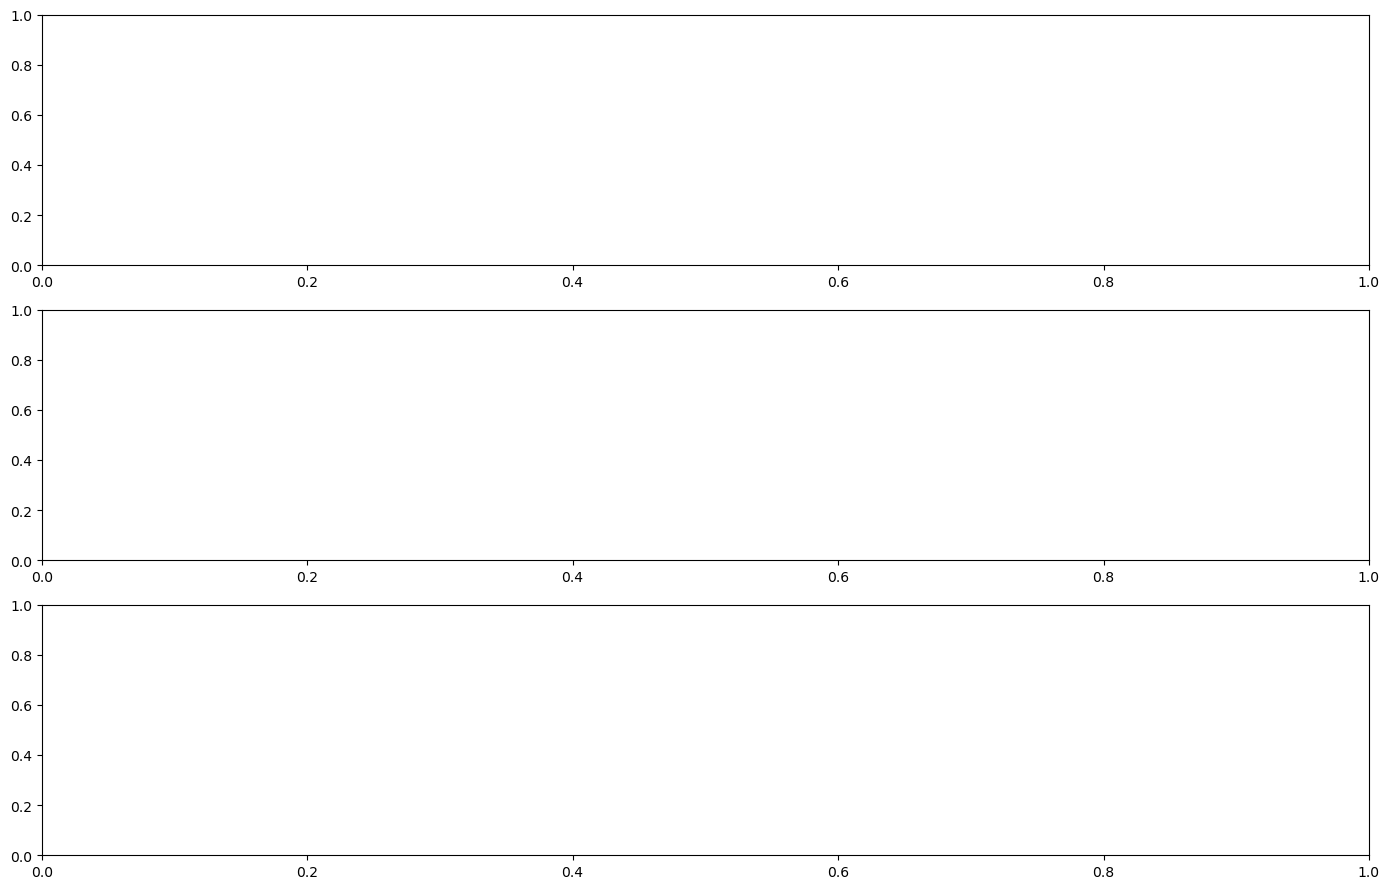

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14,9),layout='tight')
ax = [ fig.add_subplot(3,1,x) for x in range(1,4) ]
ax[0].plot(np.arange(0,len(scores)),np.log10(1+np.array(scores)))
ax[0].plot([0,5000],np.log10([7,7]),'k--')
ax[0].set_title('Game scores')
ax[1].plot(np.arange(4991),np.log10(1+np.convolve(np.ones(10)/10,scores,mode='valid')))
ax[1].plot([0,4991],np.log10([7,7]),'k--')
ax[1].set_title('Game scores, average 10 consecutive games')
ax[2].plot(np.arange(0,len(q_achieved)),q_achieved)
ax[2].set_title('Q values of state achieved at each time')
ax[2].set_ylabel('Game number')

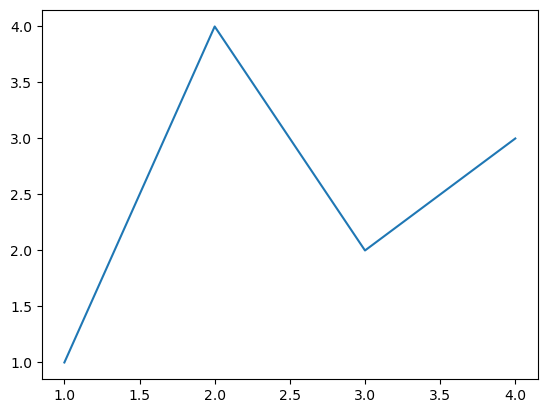

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.plot([1, 2, 3, 4], [1, 4, 2, 3])  # Plot some data on the axes.

Hooray, it has learned!  If you are getting a ten-game average score of better than 6, then you are ready to submit your model for grading.   In order to do that, you need to save the model:

In [ ]:
q_learner.save('trained_model.npz')

In [ ]:
# !python pong.py --player q_trained

<a id='section9'></a>

## Extra Credit

For extra credit, download the file <a href="mp11_extra.zip">mp11_extra.zip</a>.  The only important file in this package is:
* `tests/test_extra.py`: this contains extra tests that will evaluate your pre-trained `deep_q` learner, which should be in a file called `trained_model.pkl`.  For full credit, your model should achieve an average score of greater than 20, averaged over 10 consecutive games. 

With a quantized lookup table, it's probably not possible to achieve an average score of 20.  With a deep-Q learner, however, it is eminently possible.  In order to do the extra credit, therefore, you should just fill in the part of `submitted.py` that implements the `deep_q` learner, using pytorch to define a model structure, train it, save it, load it, and act on it.  This learner only needs to have five methods: `__init__`, `act`, `learn`, `save`, and `load`:

In [ ]:
importlib.reload(submitted)
help(submitted.deep_q.__init__)

In [ ]:
help(submitted.deep_q.act)

In [ ]:
help(submitted.deep_q.learn)

In [ ]:
help(submitted.deep_q.save)

In [ ]:
help(submitted.deep_q.load)

<a id='grade'></a>

## Grade your homework

If you've reached this point, and all of the above sections work, then you're ready to try grading your homework!  Before you submit it to Gradescope, try grading it on your own machine.  This will run some visible test cases (which you can read in `tests/test_visible.py`), and compare the results to the solutions (which you can read in `solution.json`).

The exclamation point (!) tells python to run the following as a shell command.  Obviously you don't need to run the code this way -- this usage is here just to remind you that you can also, if you wish, run this command in a terminal window.

In [ ]:
!python grade.py

Now you should try uploading your code to <a href="https://www.gradescope.com/courses/486387">Gradescope</a>.  

**Warning:** For this MP you need to update two files, not just one. 
* `trained_model.npz` should contain your trained model
* `submitted.py` should contain your code that loads and runs your trained model.

**Warning:** The autograder calculates the average score over ten random games.  If you are getting an average score above 10 almost all the time on your own computer, and if the autograder says you had a score below 10, try resubmitting to see if the next round of random games is better.

**Extra Credit:** Your extra credit should also be uploaded as two files,
* `trained_model.pkl` should contain your trained model
* `submitted.py` should contain your code that loads and runs your trained model.